In [23]:
### This file contains code to conduct the preprocessing for data
# and has been functionalized to allow for more flexible data handling
# Derived from Elastic_net.ipynb
# Key parameters are included below:
# 1.Filter by completeness; (check the number of absent entries and filter proteins below a certain threshold)
# 5.Apply a signal to noise filter to remove proteins that have a high signal to noise ratio
# 2.change expression values into log ratios as compared to the control test
# 3.Fill in the missing values using various methods (1st method is to fill in with the mean of the column)
# 3.Pull out proteins that are targeted by drugs
# 4.Sort proteins according to how much they vary
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
re_run_flag=False


In [24]:
def reorganize_data(df_raw, meta_data_cols):
    """
    Apply transformations to the raw data including extracting cell viability and reorganizing columns.
    
    Parameters:
    -----------
    df_raw : pandas.DataFrame
        Raw input dataframe containing all data
    meta_data_cols : list
        List of column indices for metadata columns
        
    Returns:
    --------
    pandas.DataFrame
        Reorganized dataframe with protein data first, then cell viability, then metadata
    """
    # Extract cell viability and organize data columns
    cell_viability = df_raw['Cell_viability%_(cck8Drug-blk)/(control-blk)*100']
    metadata_cols = df_raw.columns[meta_data_cols]
    non_metadata_cols = df_raw.columns.difference(metadata_cols)
    non_metadata_cols = non_metadata_cols.difference(['Cell_viability%_(cck8Drug-blk)/(control-blk)*100'])

    # Reorganize dataframe with protein data first, then cell viability, then metadata
    df_meta_data_at_end = pd.concat([
        df_raw[non_metadata_cols],  # Protein expression data
        cell_viability,            # Cell viability
        df_raw[metadata_cols]      # Metadata columns
    ], axis=1)
    
    return df_meta_data_at_end

def separate_metadata(data_df, metadata_indices=range(-12,0)):
    """
    Separates metadata columns from protein expression data based on provided indices.
    Expression columns are all columns not in metadata_indices.
    
    Args:
        data_df: DataFrame containing both metadata and protein expression data
        metadata_indices: List of column indices for metadata (optional)
    
    Returns:
        tuple: (metadata_df, expression_df) containing separated DataFrames
    """
    if metadata_indices is None:
        # Fallback to original behavior if no indices provided
        metadata_cols = data_df.select_dtypes(include=['object', 'bool']).columns
        expression_cols = data_df.select_dtypes(include=['float64', 'int64']).columns
    else:
        # Use provided indices to split columns
        metadata_cols = data_df.columns[metadata_indices]
        expression_cols = data_df.columns[~data_df.columns.isin(metadata_cols)]
    
    # Split the data
    metadata_df = data_df[metadata_cols].copy()
    expression_df = data_df[expression_cols].copy()
    
    return metadata_df, expression_df

def recombine_data(metadata_df, expression_df):
    """
    Recombines metadata and expression data into a single DataFrame.
    
    Args:
        metadata_df: DataFrame containing metadata
        expression_df: DataFrame containing protein expression data
    
    Returns:
        DataFrame with recombined data
    """
    # Ensure indices match
    if not metadata_df.index.equals(expression_df.index):
        raise ValueError("Metadata and expression data must have matching indices")
    
    # Combine the data, the order ensures that the metadata is at the end
    combined_df = pd.concat([expression_df, metadata_df], axis=1)
    
    return combined_df


In [25]:
def filter_by_completeness(prot_data, prot_info, completeness_threshold=0.8, metadata_indices=None):
    # Separate metadata and expression data
    meta, expr = separate_metadata(prot_data, metadata_indices)
    
    # Calculate completeness for each protein column
    col_completeness = expr.notna().mean()
    complete_proteins = col_completeness[col_completeness >= completeness_threshold].index.tolist()
    filtered_expr = expr[complete_proteins]
    
    # Calculate completeness for each row (sample)
    row_completeness = filtered_expr.notna().mean(axis=1)
    complete_rows = row_completeness[row_completeness >= completeness_threshold].index.tolist()
    filtered_expr = filtered_expr.loc[complete_rows]
    filtered_meta = meta.loc[complete_rows]
    
    # Update protein info to match filtered dataset
    filtered_info = prot_info[prot_info['proteins'].isin(complete_proteins)]
    
    # Recombine metadata and filtered expression data
    filtered_data = recombine_data(filtered_meta, filtered_expr)
    
    print(f"Filtered from {len(expr.columns)} to {len(filtered_expr.columns)} proteins")
    print(f"Filtered from {len(expr)} to {len(filtered_expr)} rows")
    print(f"Completeness threshold: {completeness_threshold}")
    return filtered_data, filtered_info


In [26]:
def filter_by_control_values(prot_data, control_id='control', metadata_indices=None):

    # Get control row by finding the row with control pert_id before separating metadata
    control_row = prot_data.loc[prot_data['pert_id'] == control_id]
    
    # Separate metadata and expression data
    meta, expr = separate_metadata(prot_data, metadata_indices)
    
    # Get protein columns (excluding pert_id)
    protein_cols = expr.columns
    starting_num_proteins = len(protein_cols)
    
    # Check which columns have values in the control row
    valid_columns = []
    for col in protein_cols:
        if not pd.isna(control_row[col].iloc[0]):
            valid_columns.append(col)
    # Filter dataset to only include columns that had entries in control row
    filtered_expr = expr[valid_columns]
    remaining_num_proteins = len(filtered_expr.columns)
    
    print(f"Filtered from {starting_num_proteins} to {remaining_num_proteins} proteins")
    
    # Recombine with metadata and expression data
    filtered_data = recombine_data(meta, filtered_expr)
    return filtered_data


In [27]:
def filter_by_cell_viability(df, cell_viability_col='Cell_viability%_(cck8Drug-blk)/(control-blk)*100'):
    initial_count = len(df)
    filtered_df = df[df[cell_viability_col].notna()]
    print(f"Filtered from {initial_count} to {len(filtered_df)} rows")
    return filtered_df


In [28]:
def convert_to_log_ratios(prot_data, control_id='control',metadata_indices=None,log_fxn=np.log2):
    #using logbase2
    # Separate metadata and expression data
    meta, expr = separate_metadata(prot_data, metadata_indices)
    
    # Identify numeric columns
    numeric_cols = expr.select_dtypes(include=[np.number]).columns
    
    # Calculate mean control values for numeric columns only
    # Use meta to identify control samples since pert_id is in metadata
    control_mask = meta['pert_id'] == control_id
    control_means = expr[control_mask][numeric_cols].mean()
    
    # Calculate log ratios for all samples including control
    log_ratios = expr.copy()
    
    # Calculate log ratios for numeric columns
    for col in numeric_cols:
        log_ratios[col] = log_fxn(expr[col] / control_means[col])
    
    print(f"Converted {len(expr)} samples to log ratios")
    
    # Recombine with metadata
    return recombine_data(meta, log_ratios)


In [29]:
def filter_signal_to_noise(
    df, 
    signal_to_noise_threshold=0.001, 
    epsilon=1e-6, 
    plot=False
):
    """
    Filters columns by signal-to-noise ratio (SNR).
    Optionally plots the CDF of SNR before and after filtering.

    Args:
        df: DataFrame with metadata and expression data.
        signal_to_noise_threshold: Threshold for filtering.
        epsilon: Small value to avoid division by zero.
        plot: If True, plot SNR CDF before and after filtering.

    Returns:
        Filtered DataFrame.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    meta, expr = separate_metadata(df)
    
    means = expr.mean()
    stds = expr.std().replace(0, 1e-6)
    snr = means.abs() / (stds + epsilon)

    keep_cols = list(snr[snr >= signal_to_noise_threshold].index)
    
    cell_viab_col = 'Cell_viability%_(cck8Drug-blk)/(control-blk)*100'
    if cell_viab_col in expr.columns and cell_viab_col not in keep_cols:
        keep_cols.append(cell_viab_col)

    # Subset expression data
    filtered_expr = expr[keep_cols]
    filtered_snr = snr[keep_cols] if len(keep_cols) > 0 else snr

    print(f"Filtered proteins by SNR: {expr.shape[1]} -> {filtered_expr.shape[1]}")

    if plot:
        # Plot CDF of SNR before and after filtering
        plt.figure(figsize=(10, 5))
        sorted_snr = np.sort(snr)
        cdf = np.arange(1, len(sorted_snr)+1) / len(sorted_snr)
        plt.plot(sorted_snr, cdf, label='Before filtering', color='blue')

        sorted_filtered_snr = np.sort(filtered_snr)
        cdf_filtered = np.arange(1, len(sorted_filtered_snr)+1) / len(sorted_filtered_snr)
        plt.plot(sorted_filtered_snr, cdf_filtered, label='After filtering', color='green')

        plt.axvline(signal_to_noise_threshold, color='red', linestyle='--', label='Threshold')
        plt.xlabel('Signal-to-Noise Ratio (SNR)')
        plt.ylabel('CDF')
        plt.title('CDF of SNR Before and After Filtering')
        plt.legend()
        plt.grid(True)

    # Recombine with metadata
    filtered_data = recombine_data(meta, filtered_expr)
    return filtered_data


In [30]:
def filter_signal_to_noise_gen2(df, signal_threshold=2.5,tole=0.001,filtering_to_use=4): #1 is filter 1, 2 is filter 2, 3 is filter 3, 4 is all filters
    df_meta, df_expr = separate_metadata(df,metadata_indices=range(-13,0))
    n_start = df_expr.shape[1]
    df_expr=df_expr.iloc[:,1:-1]
#Method 1:
#in each iteration of the while loop, we calculate the mean and std of the non-excluded samples
#we then mark the samples that are larger than 2.5*std + mean as signal
#we then exclude the signal samples from the next iteration
#we repeat this process until the mean and std change by less than tole
#we then return the indices of the proteins that pass the filter

    if filtering_to_use == 1 or filtering_to_use == 4:
        
        std_old = 0.0
        std_new = 0.0

        inds = []
        signal = np.zeros(df_expr.shape)
        excluded = np.ones(df_expr.shape)

        while (std_old == 0) or (abs(std_new - std_old) > tole): #this is the convergence criterion, if it changes by less than tole we stop
            std_old = std_new
            vec = df_expr.to_numpy().flatten() #the dataframe as a 1D vector

            # This is std dev and mean over the entire matrix
            mean = np.mean(vec[signal.flatten() == 0])
            std_new = np.std(vec[signal.flatten() == 0])
            print(f"mean: {mean:.3f}, std: {std_new:.3f}")
        

            # Get the samples that are larger than 2.5*std
            # 1 in signal means the sample > 2.5*std and vice versa
            signal = (np.abs(df_expr.to_numpy()) > signal_threshold*std_new + mean)*excluded #update signal matrix by marking samples (using the actual value that are larger than 2.5 std dev away from mean( and keeping out the excluded))
            excluded = excluded * (1-signal)
            signal_df = pd.DataFrame(signal, columns=df_expr.columns, index=df_expr.index)
            inds.extend(signal_df.any(axis=0)[signal_df.any(axis=0)].index.tolist())

        inds_method_1 = list(set(inds))

        if filtering_to_use == 1:
            print(f"Filtered from {n_start} proteins to {len(inds_method_1)} proteins by method 1")
            return recombine_data(df_meta,df_expr[inds_method_1])





    # # Signal-to-noise code, based on two assumptions:
    # # - When a data sample is excluded, the whole protein column in which that protein stays in are excluded
    # # - Mean and std are calculated using the full matrix
    if filtering_to_use == 2 or filtering_to_use == 4:
        std_old = 0.0
        std_new = 0.0
        inds = []
        signal = np.zeros(df_expr.shape)
        excluded = np.ones(df_expr.shape)

        while (std_old == 0) or (abs(std_new - std_old) > tole):
            std_old = std_new #update standard dev
            vec = df_expr.to_numpy().flatten()

            # Get the samples that are smaller than 2.5*std
            mean = np.mean(vec[signal.flatten() == 0])
            std_new = np.std(vec[signal.flatten() == 0])

            # Get the samples that are larger than 2.5*std
            # 1 in signal means the sample > 2.5*std and vice versa
            signal = (np.abs(df_expr.to_numpy()) > signal_threshold*std_new + mean)*excluded
            signal_df = pd.DataFrame(signal, columns=df_expr.columns, index=df_expr.index)

            # ind is a list of indices of columns that have at least one excluded data sample
            ind = signal_df.any(axis=0)[signal_df.any(axis=0)].index.tolist()
            inds.extend(ind)
            int_ind = [signal_df.columns.tolist().index(i) for i in ind]
            excluded[:, int_ind] = np.zeros((excluded.shape[0], len(int_ind)))

        inds_method_2 = list(set(inds))
        if filtering_to_use == 2:
            print(f"Filtered from {n_start} proteins to {len(inds_method_2)} proteins by method 2")
            return recombine_data(df_meta,df_expr[inds_method_2])



    # # Signal-to-noise code, based on two assumptions:
    # # - Only data samples passing the criteria are excluded, not the whole protein column of which they are in
    # # - Mean and std are calculated for each perturbation condition



    if filtering_to_use == 3 or filtering_to_use == 4:
        std_old = np.zeros(df_expr.shape)
        std_new = np.zeros(df_expr.shape)
        inds = []
        tole = 0.001
        signal = np.zeros(df_expr.shape)
        excluded = np.ones(df_expr.shape)
        i = -1

        while np.all(std_old == 0) or np.all(np.abs(std_new - std_old) > tole):
            i += 1
            std_old = std_new
            vec = df_expr.to_numpy()

            # Get the samples that are smaller than 2.5*std
            mask = vec*excluded
            
            mask[mask == 0.0] = np.nan
            if np.all(np.any(np.isnan(mask), axis=0)):
                print("Break")
                break
            mean = np.nanmean(mask, axis=1, keepdims=True)
            std_new = np.nanstd(mask, axis=1, keepdims=True)

            # Get the samples that are larger than 2.5*std
            # 1 in signal means the sample > 2.5*std and vice versa
            signal = (np.abs(df_expr.to_numpy()) > signal_threshold*std_new + mean)*excluded
            excluded = excluded * (1-signal)
            signal_df = pd.DataFrame(signal, columns=df_expr.columns, index=df_expr.index)
            inds.extend(signal_df.any(axis=0)[signal_df.any(axis=0)].index.tolist())

        inds_method_3 = list(set(inds))

        if filtering_to_use == 3:
            print(f"Filtered from {n_start} proteins to {len(inds_method_3)} proteins by method 3")
            return recombine_data(df_meta,df_expr[inds_method_3])



        # # To retain the highest fidelity proteins, we select the ones in the middle
        inds_final = list(set(inds_method_1).intersection(set(inds_method_2)).intersection(set(inds_method_3)))
        if filtering_to_use == 4:
            print(f"Filtered from {n_start} proteins to {len(inds_final)} proteins by all methods")
            return recombine_data(df_meta,df_expr[inds_final])

In [31]:
def iterative_signal_filtering(
    df, 
    std_threshold=2.5, 
    tole=0.001, 
    filtering_to_use=1, 
    metadata_indices=range(-13,0)
):
    #logic of the code: assume we are dealing with gaussian noise initially, and then if there are things that stand out from the noise, we pluck them out
    #then we repeat the process until it seems like we have plucked out all the signal and we are truly left with just noise, and then we return all the proteins
    #that have a single non-signal value

    import numpy as np
    import pandas as pd

    df_meta, df_expr = separate_metadata(df, metadata_indices)
    n_start = df_expr.shape[1]

    std_old = 0.0
    std_new = 0.0
    non_signal_idxs = []
    signal_matrix = np.zeros(df_expr.shape)  # assume we are dealing with gaussian noise initially (nothing is signal to start with)
    exclusion_matrix=np.ones(df_expr.shape) #since there is no signal, we exclude nothing to start with

    while (std_old == 0 or abs(std_new - std_old) > tole):
        #this logic is the same regardless of the filtering option:
        std_old = std_new
        included_vals = np.where(exclusion_matrix == 1, df_expr.to_numpy(), np.nan) #condition, true value, false value
        std_new = np.nanstd(included_vals.flatten())
        mean_new = np.nanmean(included_vals.flatten())
        matrix_of_stds = np.abs((included_vals - mean_new) / std_new) #calculates the standard deviation for all included values



        #in method 1; if an expression value looks like it is signal, we then exclude just that value from the iterations in the future
        if(filtering_to_use==1):
            signal_matrix[matrix_of_stds > std_threshold] = 1 #all values that are greater than the std threshold are signal
            exclusion_matrix=exclusion_matrix*(1-signal_matrix) #all values that are signal are excluded

        #in method 2 if an expression value looks like it is signal, we then exclude that entire protein from future iterations
        if(filtering_to_use==2):
            signal_matrix[matrix_of_stds > std_threshold] = 1 #all values that are greater than the std threshold are signal
            #now say if there is a single signal entry in a column, that entire column is signal
            signal_cols = np.where(signal_matrix.sum(axis=0) > 0)[0]
            signal_matrix[:, signal_cols] = 1
            exclusion_matrix=exclusion_matrix*(1-signal_matrix) #all values that are signal are excluded

        print(f"std_new: {std_new:.3f}, std_old: {std_old:.3f}, mean: {mean_new:.3f},")

    signal_cols = np.where(signal_matrix.sum(axis=0) > 0)[0] 
    signal_col_names = df_expr.columns[signal_cols]
    filtered_df = df_expr[signal_col_names]
    print(f"Filtered from starting proteins ({n_start}) to {filtered_df.shape[1]} signal proteins.")
    return recombine_data(df_meta,filtered_df)




In [32]:
def filter_by_mutual_information(
    df, 
    mutual_information_threshold=0.01,
    y_col='Cell_viability%_(cck8Drug-blk)/(control-blk)*100',
    rand_state=42,
    plot=False
):
    """
    Filters columns by mutual information with respect to y_col.
    Optionally plots the mutual information before and after filtering as CDFs.

    Args:
        df: DataFrame with metadata and expression data.
        mutual_information_threshold: Threshold for filtering.
        y_col: Column to compute MI against.
        rand_state: Random state for reproducibility.
        plot: If True, plot MI CDF before and after filtering.

    Returns:
        Filtered DataFrame.
    """
    from sklearn.feature_selection import mutual_info_regression
    import matplotlib.pyplot as plt
    import numpy as np

    meta, expr = separate_metadata(df)
    y = df[y_col]
    mi = mutual_info_regression(
        expr.values, 
        y.values, 
        random_state=rand_state
    )
    mi_series = pd.Series(mi, index=expr.columns)
    keep_cols = list(mi_series[mi_series >= mutual_information_threshold].index)
    cell_viab_col = 'Cell_viability%_(cck8Drug-blk)/(control-blk)*100'
    if cell_viab_col in expr.columns and cell_viab_col not in keep_cols:
        keep_cols.append(cell_viab_col)
    filtered_expr = expr[keep_cols]
    print(f"Filtered proteins by mutual information: {expr.shape[1]} -> {filtered_expr.shape[1]}")

    if plot:
        # Plot both CDFs on the same graph
        plt.figure(figsize=(10, 6))
        # CDF before filtering
        sorted_mi = np.sort(mi_series)
        cdf = np.arange(1, len(sorted_mi)+1) / len(sorted_mi)
        plt.plot(sorted_mi, cdf, color='skyblue', label='All Features')
        # CDF after filtering
        mi_filtered = mi_series[keep_cols]
        sorted_mi_filtered = np.sort(mi_filtered)
        cdf_filtered = np.arange(1, len(sorted_mi_filtered)+1) / len(sorted_mi_filtered)
        plt.plot(sorted_mi_filtered, cdf_filtered, color='lightgreen', label='Filtered Features')
        plt.axvline(mutual_information_threshold, color='red', linestyle='--', label='Threshold')
        plt.title('Mutual Information CDF Before and After Filtering')
        plt.xlabel('Mutual Information')
        plt.ylabel('Cumulative Density')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

    # Recombine with metadata
    filtered_data = recombine_data(meta, filtered_expr)
    return filtered_data

In [33]:
def filter_by_variance(df, variance_threshold=0.01, plot=False):
    import matplotlib.pyplot as plt
    import numpy as np
    # Calculate variance for each protein
    meta, expr = separate_metadata(df)
    protein_var = expr.var()

    # Sort proteins by variance in descending order
    sorted_var = protein_var.sort_values(ascending=False)

    # Filter proteins by variance threshold
    keep_cols = sorted_var[sorted_var > variance_threshold].index.tolist()
    filtered_expr = expr[keep_cols]
    print("Proteins before filtering: ", len(expr.columns))
    print("Proteins after filtering (variance > ", variance_threshold, "): ", len(keep_cols))
    if plot:
        plt.figure(figsize=(10, 5))
        # CDF for all variances
        sorted_all = np.sort(sorted_var.values)
        cdf_all = np.arange(1, len(sorted_all)+1) / len(sorted_all)
        plt.plot(sorted_all, cdf_all, color='skyblue', label='All Proteins')
        # CDF for filtered variances
        sorted_filtered = np.sort(filtered_expr.var().values)
        cdf_filtered = np.arange(1, len(sorted_filtered)+1) / len(sorted_filtered)
        plt.plot(sorted_filtered, cdf_filtered, color='lightgreen', label='Filtered Proteins')
        plt.axvline(variance_threshold, color='red', linestyle='--', label='Variance Threshold')
        plt.xlabel('Variance')
        plt.ylabel('Cumulative Density')
        plt.title('Protein Variance CDF Before and After Filtering')
        plt.legend()
        plt.tight_layout()
    # Recombine with metadata
    filtered_data = recombine_data(meta, filtered_expr)
    return filtered_data

In [34]:
def ablation_study(df,folds=5,target_column='Cell_viability%_(cck8Drug-blk)/(control-blk)*100',model='ElasticNet',n_features_to_select=100):
    from sklearn.model_selection import train_test_split

    #generating five folds of the data:
    meta, expr=separate_metadata(df)
    overall_data=expr
    folds=np.arange(0,4)
    train_splits=[]
    test_splits=[]
    ys=[]   
    for trial in folds:
        train,test=train_test_split(overall_data,test_size=0.2,random_state=np.random.randint(1,1000000))
        ys.append(train[target_column])
        train.drop(columns=[target_column],inplace=True)
        test.drop(columns=[target_column],inplace=True)
        train_splits.append(train)
        test_splits.append(test)
    #running ablation studies on each of the five folds:
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import ElasticNetCV
    top_100_features=[]

    # #injecting noise temporarily:
    # for i,training_data in enumerate(train_splits):
    #     noisy_train = training_data + np.random.normal(0, 10, size=training_data.shape)
    #     train_splits[i] = noisy_train

    if model=='ElasticNet':
        from sklearn.linear_model import ElasticNet
        model=ElasticNet(
            alpha=0.01,
            l1_ratio=0.5,
            max_iter=500,
            random_state=42,
        )
    for trial in folds:
        rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
        rfe.fit(train_splits[trial],ys[trial])
        top_100_features.append(train_splits[trial].columns[rfe.support_])
        print(top_100_features[trial])

    # Check for consistency across splits
    for i in range(len(top_100_features)):
        for j in range(i+1, len(top_100_features)):
            overlap = set(top_100_features[i]).intersection(set(top_100_features[j]))
            print(f"Overlap between split {i} and {j}: {len(overlap)} features")
    return(top_100_features)


def overlapping_features(top_100_features_list,n_prots_to_keep=100):
        # Create a flat list of all proteins across all folds
    all_proteins = sorted(set([protein for fold in top_100_features_list for protein in fold]))

    # Create a matrix (DataFrame) where rows are proteins and columns are folds
    protein_fold_matrix = pd.DataFrame(0, index=all_proteins, columns=[f"Fold_{i}" for i in range(len(top_100_features_list))])

    # Fill the matrix: 1 if protein is present in that fold, 0 otherwise
    for i, fold in enumerate(top_100_features_list):
        protein_fold_matrix.loc[fold, f"Fold_{i}"] = 1

    # Add a column for the total count across all folds
    protein_fold_matrix['Total_Count'] = protein_fold_matrix.sum(axis=1)

    print("Protein occurrence matrix across folds:")
    print(protein_fold_matrix)

    # Optionally, show proteins sorted by how often they appear
    print("\nProteins sorted by frequency across folds:")
    protein_fold_matrix.sort_values(by='Total_Count',ascending=False,inplace=True)
    print(protein_fold_matrix['Total_Count'])
    top_100=protein_fold_matrix.index.tolist()[:n_prots_to_keep]
    return(top_100)

In [35]:
def get_targeted_proteins(prot_data, prot_info, id_key='Uniprot.ID'):
    """
    Identifies proteins that are targeted by drugs in the dataset.
    
    Args:
        prot_data: DataFrame containing protein expression data
        prot_info: DataFrame containing protein metadata
        id_key: Column name containing target IDs (default: 'Uniprot.ID')
    
    Returns:
        List of protein IDs that are targeted by drugs
    """
    # Get all unique uniprot ID's for each trial from data.csv
    #This is from data.csv file and the uniprot ID says which proteins are targeted by drugs
    all_targets = prot_data[id_key].dropna().unique()
    
    # Split targets that may be comma or semicolon-separated and flatten the list
    target_list = []
    #if there are multiple targets, split them by comma or semicolon, then convert to uppercase and get rid of whitespace and then add to target_list
    for targets in all_targets:
        if isinstance(targets, str):
            target_list.extend([t.strip().upper() for t in re.split(r'[;,]', targets)])
    
    # Get unique targets, (just looking at the set which gets rid of duplicates)
    unique_targets = list(set(target_list))
    
    # Filter to only include targets that exist in our protein measurements
    valid_targets = [t for t in unique_targets if t in prot_data.columns]
    
    print(f"Found {len(valid_targets)} unique targeted proteins out of {len(unique_targets)} total targets")
    return valid_targets


In [36]:
def make_pert_id_to_targets_dict(prot_log):
    #make blank dictionary
    pert_id_to_targets_dict={}
    #get the pert id and uniprot id from the prot_log dataframe
    for index, row in prot_log.iterrows():
        pert_id=row['pert_id']
        uniprot_id=row['Uniprot.ID']
        id_list=[]
        #split the uniprot ID by comma or semicolon, doing some basic checks to make sure it's not empty:
        if uniprot_id is not np.nan:
            if 'not' not in str(uniprot_id).lower():
                id_list.extend([t.strip().upper() for t in re.split(r'[;,]', uniprot_id)])
        #associate all the uniprot ID's with the pert id in the dict.
        pert_id_to_targets_dict[pert_id]=id_list
    return pert_id_to_targets_dict


In [37]:
def make_activity_nodes(targeted_proteins_with_metadata,pert_id_to_targets_dict):
    activity_nodes=targeted_proteins_with_metadata.copy()
    #scan through each protein column
    for protein in targeted_proteins_with_metadata.columns:

        #scan through each row and get the pert_id, then look it up in the dictionary to see if the protein is targeted;
        for index, row in targeted_proteins_with_metadata.iterrows():

            pert_id=row['pert_id']

            #check if the pert_id is in the pert_ID_list
            if pert_id in pert_id_to_targets_dict.keys():
                #check if the protein is in the dictionary
                if protein in pert_id_to_targets_dict[pert_id]:
                    pass
                else:
                    if protein in activity_nodes.columns:
                        activity_nodes.loc[index,protein]=0

    #cleave off last 12 columns for metadata:
    activity_nodes=activity_nodes.iloc[:,:-12]
    return activity_nodes

In [38]:
def get_targeted_indices(targeted_proteins_with_metadata):
    protein_list=targeted_proteins_with_metadata.columns
    targeted_indices = []
    #first check that it is proteins:
    for index, Uniprots in enumerate(targeted_proteins_with_metadata['Uniprot.ID']):
        if Uniprots is not np.nan:
            if 'not' not in str(Uniprots).lower():
                id_list=[]
                id_list.extend([t.strip().upper() for t in re.split(r'[;,]', Uniprots)])
                #then check that the protein is in the list of targeted proteins:
                for i in id_list:
                    if i in protein_list:
                        targeted_indices.append(index)
                        break
    return targeted_indices

In [39]:
def make_cellbox_files(prot_log, acti_df, file_prefix, file_path):
    #cellbox takes in three files: expr.csv, pert.csv, node_Index.csv
#expr.csv is the expression data, of size drug trials x(proteins+phenotypes+activity nodes)
#pert.csv is the perturbation data, of size drug trials x(proteins+phenotypes+activity nodes); the proteins and phenotypes are zeroed out
#the activity nodes indicate the activity of each protein in each drug trial, and so therefore should be of size #of targeted proteins, 
#these are activated.

    """
    Creates CellBox input files from processed data.
    
    Args:
        prot_log: DataFrame containing log ratios
        acti_df: DataFrame containing activity nodes
        file_prefix: Prefix for output files
        file_path: Path to save output files
    
    Returns: cellbox_files
    """

    expr_csv = prot_log.merge(acti_df, left_index=True, right_index=True)

    # Create perturbation data
    zeros_pert = pd.DataFrame(np.zeros_like(prot_log), columns=prot_log.columns, index=prot_log.index)
    acti_df_arctanh = pd.DataFrame(
        np.arctanh(acti_df.to_numpy().astype(float)),
        columns=acti_df.columns, index=acti_df.index
    )
    pert_csv = pd.merge(zeros_pert, acti_df_arctanh, left_index=True, right_index=True)

    # Create node index
    columns = pert_csv.columns.tolist()
    node_index_csv = pd.DataFrame({"A": columns})

    # Save files
    expr_csv.to_csv(
        (file_path + file_prefix + "expr.csv"),
        header=False,
        index=False
    )
    pert_csv.to_csv(
        (file_path + file_prefix + "pert.csv"),
        header=False,
        index=False
    )
    node_index_csv.to_csv(
        (file_path + file_prefix + "node_Index.csv"),
        sep=" ",
        header=False,
        index=False
    )
    return expr_csv, pert_csv, node_index_csv

Stage 1: Reading in data and essential filtering
Filtered from 8544 to 5733 proteins
Filtered from 94 to 91 rows
Completeness threshold: 0.95
Filtered from 5733 to 5722 proteins
Filtered from 91 to 91 rows
Converted 91 samples to log ratios
Stage 1 complete
std_new: 0.032, std_old: 0.000, mean: -0.002,
std_new: 0.023, std_old: 0.032, mean: -0.002,
std_new: 0.020, std_old: 0.023, mean: -0.002,
std_new: 0.019, std_old: 0.020, mean: -0.002,
std_new: 0.018, std_old: 0.019, mean: -0.002,
Filtered from starting proteins (5721) to 3751 signal proteins.
mean: -0.002, std: 0.032
mean: -0.002, std: 0.023
mean: -0.002, std: 0.030
mean: -0.002, std: 0.032
mean: -0.002, std: 0.032
Filtered from 5721 proteins to 3056 proteins by method 1
Filtered proteins by mutual information: 3057 -> 1483


KeyboardInterrupt: 

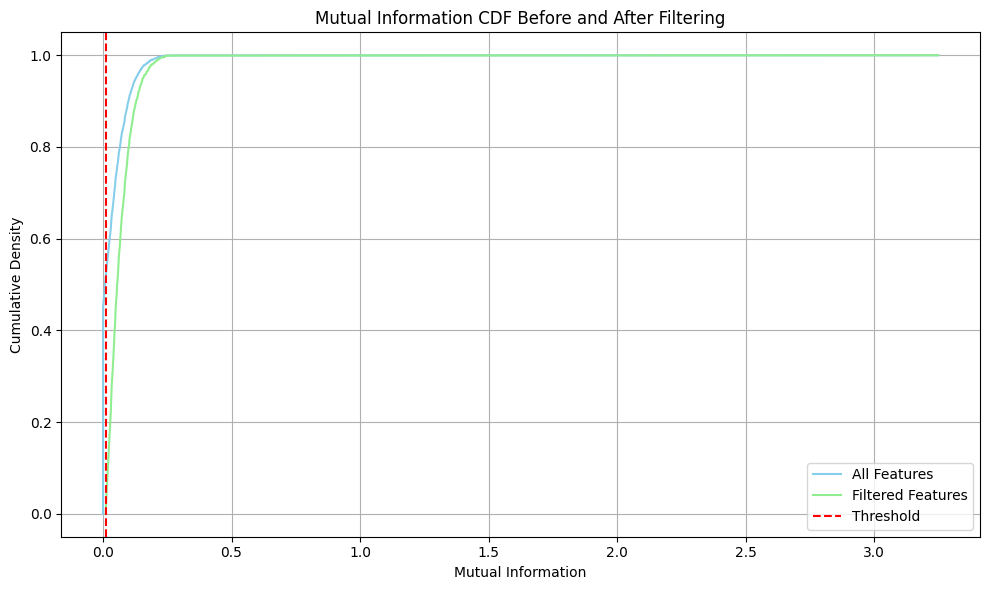

In [ ]:
#MAIN METHOD
#NOTE Things to change for different datasets:
if(re_run_flag==False):
    print('Stage 1: Reading in data and essential filtering')
    data_path=r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\preprocessing\data.csv'
    prot_info_path=r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\preprocessing\prots_info.csv'
    df_prot_info=pd.read_csv(prot_info_path)
    df_raw=pd.read_csv(data_path)
    df_control_row = df_raw[df_raw['pert_id']=='control'] #pulls out the control row
    meta_data_cols = [0] + list(range(-12, -2))+[-1] #The metadata columns, must be changed for different datasets
    #NOTE the function explicitly pulls out cell viability, that would also need to be changed for different datasets
    df_raw=reorganize_data(df_raw, meta_data_cols)
    #applying transforms:
    #NOTE now that the metadata is at the end, we need to update the metadata indices
    meta_data_cols = range(-12,0)
    #DONE READING IN DATA AND RESHAPING


    #BASIC ESSENTIAL FILTERING AND TRANSFORM
    filtered_by_completeness, filtered_by_completeness_info=filter_by_completeness(df_raw, df_prot_info,completeness_threshold=0.95,metadata_indices=meta_data_cols) 
    filtered_by_control_values=filter_by_control_values(filtered_by_completeness, control_id='control',metadata_indices=meta_data_cols)
    filtered_by_cell_viability=filter_by_cell_viability(filtered_by_control_values)
    log_ratios=convert_to_log_ratios(filtered_by_control_values, control_id='control',metadata_indices=meta_data_cols) 
    log_ratios=log_ratios.fillna(log_ratios.mean()) #fill in with the mean of the column
    assert not separate_metadata(log_ratios)[1].isna().any().any(), "There are NA values in the log_ratios expression dataframe"
    re_run_flag=True
    print('Stage 1 complete')


# #/////////////////////////////////////////////////////////////////
#SPLITTING OFF TARGETED PROTEIN DATA:
print('Stage 2: Splitting off targeted protein data')
targeted_proteins=get_targeted_proteins(df_raw,df_prot_info)
# Split off metadata and expression data from log_ratios
log_meta, log_expr = separate_metadata(log_ratios,metadata_indices=range(-13,0))
targeted_prots_in_log = [col for col in log_expr.columns if col in targeted_proteins]
targeted_proteins_df = recombine_data(log_meta, log_expr[targeted_prots_in_log])
remaining_proteins_df = recombine_data(log_meta, log_expr[[col for col in log_expr.columns if col not in targeted_prots_in_log]])
print(f"Number of targeted proteins: {len(targeted_prots_in_log)}")
print(f"Number of non-targeted proteins: {len([col for col in log_expr.columns if col not in targeted_prots_in_log])}")
print('Stage 2 complete')
#////////////////////////////////////////////////////////////////

#FILTERING NON-TARGETED PROTEINS:
print('Stage 3: Filtering non-targeted proteins')

FSNR_rem=iterative_signal_filtering(remaining_proteins_df,std_threshold=3,tole=0.001,filtering_to_use=1,metadata_indices=range(-13,0))
FMI_rem=filter_by_mutual_information(FSNR_rem,mutual_information_threshold=0.01,plot=True)
plt.xlim(0,1)
plt.show()
# filtered_by_signal_to_noise=filter_signal_to_noise(filtered_by_mutual_information,signal_to_noise_threshold=0.5,epsilon=1e-3,plot=True)
# plt.xlim(0,3)
# plt.show()
FV_rem=filter_by_variance(FMI_rem,variance_threshold=0.0005,plot=True)
plt.xlim(0,.01)
plt.show()
print('Stage 3 complete')
#///////////////////////////////////////////////////////////////////////////
#FILTERING TARGETED PROTEINS:
print('Stage 4: Filtering targeted proteins')
FSNR_tgt=iterative_signal_filtering(targeted_proteins_df,std_threshold=2,tole=0.001,filtering_to_use=1,metadata_indices=range(-13,0))
FMI_tgt=filter_by_mutual_information(FSNR_tgt,mutual_information_threshold=0.01,plot=True)
plt.xlim(0,1)
plt.show()
print('Stage 4 complete')
#//////////////////////////////////////////////////////////
print('stage 5: ablation studies on the targeted proteins')
top_12_tgtd=ablation_study(FMI_tgt,folds=5,model='ElasticNet',n_features_to_select=12)
top_12_tgtd_prots=overlapping_features(top_12_tgtd)
print('stage 5 complete')
#////////////////////////////////////////////////////////
print('stage 6: ablation studies on the non-targeted proteins')
top_87_non_tgtd=ablation_study(FV_rem,folds=5,model='ElasticNet',n_features_to_select=87)
top_87_non_tgtd_prots=overlapping_features(top_87_non_tgtd,n_prots_to_keep=87)
print('stage 6 complete')

#/////////////////////////////////////////////////////////////////
print('stage 7: generating cellbox files')
log_ratios = log_ratios * 37

final_df=recombine_data(log_meta,log_ratios[top_87_non_tgtd_prots])
top_87_non_tgtd_prots.append('Cell_viability%_(cck8Drug-blk)/(control-blk)*100')

targets_dict=make_pert_id_to_targets_dict(final_df)
activity_nodes=make_activity_nodes(recombine_data(log_meta.iloc[:,1:],log_ratios[top_12_tgtd_prots]),targets_dict)
# Filter out rows from both activity_nodes and log_ratios where the row in activity_nodes is all zeros
activity_nodes_nonzero_mask = ~(activity_nodes == 0).all(axis=1)
activity_nodes = activity_nodes.loc[activity_nodes_nonzero_mask]
log_ratios = log_ratios.loc[activity_nodes_nonzero_mask]


# cellbox_files=make_cellbox_files(log_ratios[top_87_non_tgtd_prots],activity_nodes,file_prefix='final_x37',file_path='Intermediate_files/')


# print('stage 7 complete')






### Legacy

In [ ]:
tgtd_prots_cellbox=make_cellbox_files(tgtd_log_ratios,activity_nodes,
                   file_prefix='directly_targeted_proteins',
                   file_path=r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Data\run1'
)

OSError: Cannot save file into a non-existent directory: 'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Data'

In [ ]:
# Get the targeted proteins from the log_ratios dataframe
targeted_proteins=
targeted_proteins_df = log_ratios[targeted_proteins]
targeted_proteins_df.to_csv('Intermediate_files/targeted_proteins_df.csv', index=False)
# Combine with metadata columns
targeted_proteins_with_metadata = pd.concat([
    targeted_proteins_df,
    log_ratios.iloc[:, meta_data_cols]
], axis=1)

# Display the shape of the resulting dataframe
print(f"Shape of targeted proteins dataframe: {targeted_proteins_with_metadata.shape}")
# targeted_proteins_with_metadata.to_csv('targeted_proteins_with_metadata.csv', index=False)

pert_id_to_targets_dict=make_pert_id_to_targets_dict(targeted_proteins_with_metadata)

tgt_indices=get_targeted_indices(targeted_proteins_with_metadata)
# Write tgt_indices to a file
tgt_indices_file = "Intermediate_files/tgt_indices.txt"
with open(tgt_indices_file, "w") as f:
    for idx in tgt_indices:
        f.write(str(idx) + "\n")
print(f"tgt_indices written to {tgt_indices_file}")

#
targeted_proteins_with_metadata=targeted_proteins_with_metadata.loc[tgt_indices]


Filtered from 8544 to 5733 proteins
Completeness threshold: 0.95
Converted 94 samples to log ratios
Found 61 unique targeted proteins out of 277 total targets
targeted_proteins written to Intermediate_files/targeted_proteins.txt
Shape of targeted proteins dataframe: (94, 73)
tgt_indices written to Intermediate_files/tgt_indices.txt


In [ ]:
#select targeted rows
targeted_proteins=get_targeted_proteins(log_ratios, df_prot_info) #seems like it works
# Write targeted_proteins to a file
with open('Intermediate_files/targeted_proteins.txt', 'w') as f:
    for prot in targeted_proteins:
        f.write(str(prot) + '\n')
print("targeted_proteins written to Intermediate_files/targeted_proteins.txt")
tgtd_log_ratios=log_ratios.loc[tgt_indices]

#select targeted proteins:
tgtd_log_ratios=tgtd_log_ratios[targeted_proteins +['Cell_viability%_(cck8Drug-blk)/(control-blk)*100']]
tgtd_log_ratios.fillna(0,inplace=True)
tgtd_log_ratios.to_csv('Intermediate_files/tgtd_log_ratios.csv', index=False)
activity_nodes=make_activity_nodes(targeted_proteins_with_metadata,pert_id_to_targets_dict)
activity_nodes=activity_nodes.loc[tgt_indices]
activity_nodes.fillna(0,inplace=True)

In [ ]:
#CUTTING DOWN TO ONLY ROWS WITH TARGETED PROTEINS:
df_of_neighbors=pd.read_csv(r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Testing_encodings\String_adjacency\protein_neighbors_and_degrees.csv')
filtered_log_ratios=log_ratios.loc[tgt_indices]
second_deg_neighbors=df_of_neighbors['second_order'].tolist()
second_deg_neighbors_in_prots = [neighbor for neighbor in second_deg_neighbors if neighbor in filtered_log_ratios.columns]
filtered_log_ratios=filtered_log_ratios[second_deg_neighbors_in_prots +['Cell_viability%_(cck8Drug-blk)/(control-blk)*100']]

#shitty patching of holes but for now sufficient:
filtered_log_ratios.fillna(0,inplace=True)
activity_nodes.fillna(0,inplace=True)
#should be good now to run the cellbox_file_maker
x=make_cellbox_files(filtered_log_ratios,activity_nodes,
                   file_prefix='_test_',
                   file_path=r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Data\STRINGDB_encodings'
)